In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.0 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split

import timm
import timm.optim
import timm.scheduler
from timm.data import ImageDataset, create_dataset, create_loader
from timm.data.transforms_factory import create_transform

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from PIL import Image

import evaluate

import numpy as np
import pandas as pd
from scipy import stats

from tqdm.notebook import tqdm

import glob

from sklearn.model_selection import KFold

from copy import copy

import shutil
import os
import skimage.io as sk

2024-05-06 12:05:45.096717: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 12:05:45.096830: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 12:05:45.205457: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
# List all available models
timm.list_models("")

['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

In [6]:
# model_name = "timm/maxvit_tiny_tf_224.in1k"
model_name = 'timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k'

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import timm
import numpy as np
from tqdm import tqdm

# Settings
num_epochs = 6
num_accumulate = 4

# Criterion and Metric
criterion = nn.CrossEntropyLoss()
metric = evaluate.load("f1")

In [8]:
train_path = '/kaggle/input/ml-dataset/dataset/training'
val_path = '/kaggle/input/ml-dataset/dataset/test'

In [9]:
from torchvision import datasets, transforms

train_batch_size = 16
eval_batch_size = 16

data_transforms = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(
    root=train_path,
    transform=data_transforms
)
# validation dataset
valid_dataset = datasets.ImageFolder(
    root=val_path,
    transform=data_transforms
)

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_dataloader = DataLoader(valid_dataset, batch_size=eval_batch_size, shuffle=False)

In [10]:
# Check the first few batches
for inputs, targets in train_dataloader:
    print("Sample inputs size:", inputs.size())
    print("Sample targets:", targets)
    break

Sample inputs size: torch.Size([16, 3, 448, 448])
Sample targets: tensor([2, 0, 1, 3, 1, 3, 2, 1, 1, 0, 1, 3, 1, 3, 2, 3])


0


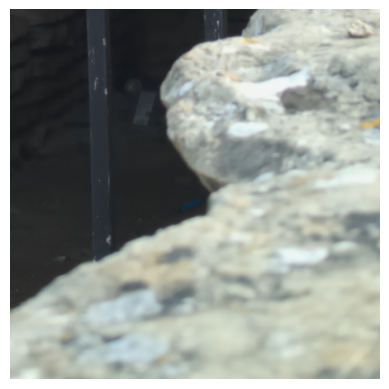

In [11]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

def show_image(tensor):
    to_image = T.ToPILImage()
    img = to_image(tensor)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

img_tensor, label = train_dataset[0]
print(label)
show_image(img_tensor)

In [12]:
# Model, Optimizer, and Scheduler
model = timm.create_model(model_name, pretrained=True, num_classes=4)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = torch.nn.DataParallel(model)
model = model.to(device)


optimizer = timm.optim.create_optimizer_v2(model, opt="AdamW", lr=1e-3)
optimizer = timm.optim.Lookahead(optimizer, alpha=0.5, k=6)

scheduler = timm.scheduler.create_scheduler_v2(optimizer, num_epochs=num_epochs)[0]


best_metric_val = -999
for epoch in range(num_epochs):
    model.train()
    
    train_loss_epoch = []
    val_loss_epoch = []
    
    train_preds = []
    train_targets = []
    
    val_preds = []
    val_targets = []
    
    num_updates = epoch * len(train_dataloader)

    # Training Loop
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_dataloader)):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs.to(device))
        loss = criterion(outputs, targets.to(device))
        
        loss.backward()

        if ((batch_idx + 1) % num_accumulate == 0) or (batch_idx + 1 == len(train_dataloader)):
            optimizer.step()
            scheduler.step_update(num_updates=num_updates)
            optimizer.zero_grad()

        train_loss_epoch.append(loss.item())
        train_preds.extend(outputs.argmax(dim=-1).detach().cpu().tolist())
        train_targets.extend(targets.tolist())
        
    optimizer.sync_lookahead()
    scheduler.step(epoch + 1)

    # Validation Loop
    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(val_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.to(device))
            val_loss_epoch.append(loss.item())
            val_preds.extend(outputs.argmax(dim=-1).detach().cpu().tolist())
            val_targets.extend(targets.tolist())

    # Calculate Metrics
    metric_train = metric.compute(predictions=train_preds, references=train_targets, average="macro")["f1"]
    metric_val = metric.compute(predictions=val_preds, references=val_targets, average="macro")["f1"]

    # Best Model Check
    if metric_val > best_metric_val:
        best_metric_val = metric_val
        if torch.cuda.current_device() == 0:
            torch.save(model, f"best_model_eva02_base_patch14_448_6_epoch.pt")

    print(f"Epoch {epoch}: Train Loss {np.mean(train_loss_epoch)}, Val Loss {np.mean(val_loss_epoch)}, Train F1 {metric_train}, Val F1 {metric_val}")

model.safetensors:   0%|          | 0.00/348M [00:00<?, ?B/s]

Using 2 GPUs!


100%|██████████| 250/250 [03:30<00:00,  1.19it/s]


Epoch 0: Train Loss 1.3924933173315865, Val Loss 1.386360583782196, Train F1 0.24716798963265219, Val F1 0.11979166666666666


100%|██████████| 250/250 [03:11<00:00,  1.31it/s]


Epoch 1: Train Loss 1.3865708927427018, Val Loss 1.3869201993942262, Train F1 0.23438007013411666, Val F1 0.1


100%|██████████| 250/250 [03:06<00:00,  1.34it/s]


Epoch 2: Train Loss 1.386745814050947, Val Loss 1.3862986297607423, Train F1 0.25048913183985855, Val F1 0.10235057878573116


100%|██████████| 250/250 [03:10<00:00,  1.31it/s]


Epoch 3: Train Loss 1.3865279574394227, Val Loss 1.3862983980178833, Train F1 0.24018200563310424, Val F1 0.1


100%|██████████| 250/250 [03:10<00:00,  1.31it/s]


Epoch 4: Train Loss 1.3863887894494193, Val Loss 1.3862960925102235, Train F1 0.2314312963050309, Val F1 0.10142992711375955


100%|██████████| 250/250 [03:09<00:00,  1.32it/s]


Epoch 5: Train Loss 1.3863203714915684, Val Loss 1.3862976222038268, Train F1 0.18013837645720443, Val F1 0.13621357620716776


100%|██████████| 250/250 [03:04<00:00,  1.35it/s]


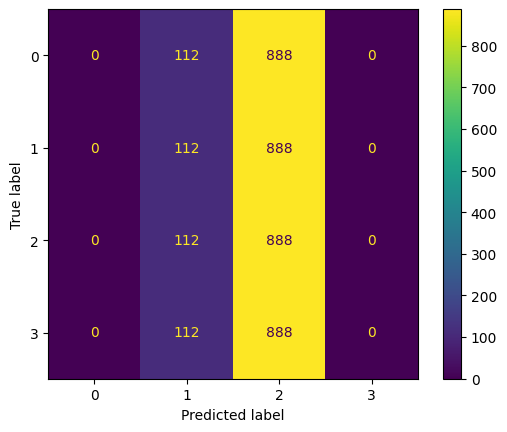

In [13]:
# loaded_model = torch.load("/kaggle/input/maxvit_10_20_epoch/pytorch/maxvit_10_6_epoch/1/best_model.pt")
loaded_model = model
predictions = []
references = []

loaded_model.eval()
with torch.no_grad():
    for batch in tqdm(val_dataloader):
        inputs, targets = batch
        outputs = loaded_model(inputs.to(device))

        # Log Values
        predictions += outputs.argmax(-1).detach().cpu().tolist()
        references += targets.tolist()

cm = confusion_matrix(references, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [14]:
# data_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
# ])


# test_dataloader = ImageDataset("/kaggle/input/intel-image-classification/seg_pred/seg_pred", transform=data_transforms)

In [15]:
# # test_files = glob.glob("/kaggle/input/alaska2-image-steganalysis/Test/*.jpg")
# test_files = glob.glob("/kaggle/input/intel-image-classification/seg_pred/seg_pred/*.jpg")

In [16]:
# data_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
# ])

In [17]:
# # Dictionary to store final answers
# answers_final = dict()

# # Load the model
# loaded_model = torch.load(f"/kaggle/working/best_model_MaXViT_6_epoch.pt")
# loaded_model.eval()  # Make sure the model is in evaluation mode

# val_preds = []

# # Ensure we're not updating gradients
# with torch.no_grad():
#     # Loop through the test files and generate predictions
#     for i, f in enumerate(tqdm(test_files)):
#         if i >= 10:
#             break

#         # Extract the filename without the extension as the key
#         key = f.split("/")[-1].split(".")[0]

#         # Open the image, convert it to RGB, and transform it
#         img = Image.open(f).convert("RGB")
#         transformed = data_transforms(img).unsqueeze(0).to(device)

#         # Generate predictions using the loaded model
#         y_pred = loaded_model(transformed)

#         # Find the class with the maximum score and convert to a list
#         pred_class = y_pred.argmax(-1).detach().cpu().tolist()

#         # Store predictions
#         val_preds += pred_class
#         answers_final[key] = pred_class

In [18]:
# answers_final

In [19]:
# submission = pd.read_csv('/kaggle/input/alaska2-image-steganalysis/sample_submission.csv')

In [20]:
# for file_id, label in answers_final.items():
#     file_name = f'{file_id}.jpg'
#     if file_name in submission['Id'].values:
#         submission.loc[submission['Id'] == file_name, 'Label'] = label[0]

# # Save the updated submission file
# submission.to_csv('updated_submission.csv', index=False)

# print("Updated submission file is saved as 'updated_submission.csv'.")